<a href="https://colab.research.google.com/github/ShaunakSen/AI-for-Web-Accessibility/blob/master/Image_Captioning_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to Develop a Deep Learning Photo Caption Generator from Scratch

[link](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

### Download and extract the dataset

In [0]:
# import all libraries here
from urllib.request import urlopen
from zipfile import ZipFile
import os
import numpy as np
import h5py



import pickle
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

Using TensorFlow backend.


In [0]:
os.listdir('/content/')

['.config',
 'Flickr8k_text',
 'Flickr8k_Dataset',
 'descriptions.txt',
 'features.pkl',
 'sample_data']

In [0]:
# check if zip file is not present in the tmp directory, else download

if 'Flickr8k_Dataset.zip' not in os.listdir('/tmp'):

  zipurl = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
      # Download the file from the URL
  zipresp = urlopen(zipurl)
      # Create a new file on the hard drive
  tempzip = open("/tmp/Flickr8k_Dataset.zip", "wb")
      # Write the contents of the downloaded file into the new file
  tempzip.write(zipresp.read())
      # Close the newly-created file
  tempzip.close()


In [0]:
if 'Flickr8k_text.zip' not in os.listdir('/tmp'):

  zipurl = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
      # Download the file from the URL
  zipresp = urlopen(zipurl)
      # Create a new file on the hard drive
  tempzip = open("/tmp/Flickr8k_text.zip", "wb")
      # Write the contents of the downloaded file into the new file
  tempzip.write(zipresp.read())
      # Close the newly-created file
  tempzip.close()


In [0]:
if 'Flickr8k_Dataset' not in os.listdir('/content/'):

  # Re-open the newly-created file with ZipFile()
  zf = ZipFile("/tmp/Flickr8k_Dataset.zip")
      # Extract its contents into <extraction_path>
      # note that extractall will automatically create the path
  zf.extractall(path = './Flickr8k_Dataset')
      # close the ZipFile instance
  zf.close()

In [0]:
if 'Flickr8k_text' not in os.listdir('/content/'):

  # Re-open the newly-created file with ZipFile()
  zf = ZipFile("/tmp/Flickr8k_text.zip")
      # Extract its contents into <extraction_path>
      # note that extractall will automatically create the path
  zf.extractall(path = './Flickr8k_text')
      # close the ZipFile instance
  zf.close()

The dataset is present in the following locations:

1. Flickr8k_Dataset
2. Flickr8k_text

The dataset has a pre-defined training dataset (6,000 images), development dataset (1,000 images), and test dataset (1,000 images).

One measure that can be used to evaluate the skill of the model are BLEU scores.

- BLEU-1: 0.401 to 0.578.
- BLEU-2: 0.176 to 0.390.
- BLEU-3: 0.099 to 0.260.
- BLEU-4: 0.059 to 0.170.

We describe the BLEU metric more later when we work on evaluating our model.

Next, let’s look at how to load the images.

### Prepare Photo Data

We will use a pre-trained model to interpret the content of the photos.

There are many models to choose from. In this case, we will use the Oxford Visual Geometry Group, or VGG, model that won the ImageNet competition in 2014. Learn more about the model here:

[](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)

Keras provides this pre-trained model directly. Note, the first time you use this model, Keras will download the model weights from the Internet, which are about 500 Megabytes. This may take a few minutes depending on your internet connection.


We could use this model as part of a broader image caption model. The problem is, it is a large model and running each photo through the network every time we want to test a new language model configuration (downstream) is redundant.

Instead, we can pre-compute the “photo features” using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset. It is no different to running the photo through the full VGG model; it is just we will have done it once in advance.

This is an optimization that will make training our models faster and consume less memory.

We can load the VGG model in Keras using the VGG class. We will remove the last layer from the loaded model, as this is the model used to predict a classification for a photo. We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. These are the “features” that the model has extracted from the photo.

Keras also provides tools for reshaping the loaded photo into the preferred size for the model (e.g. 3 channel 224 x 224 pixel image).

Below is a function named extract_features() that, given a directory name, will load each photo, prepare it for VGG, and collect the predicted features from the VGG model. The image features are a 1-dimensional 4,096 element vector.

The function returns a dictionary of image identifier to image features.

We can call this function to prepare the photo data for testing our models, then save the resulting dictionary to a file named ‘features.pkl‘.

In [0]:
model=VGG16()

model.summary()


In [0]:
print ("No of images:", len(os.listdir(path='./Flickr8k_Dataset/Flicker8k_Dataset/')))

No of images: 8091


In [0]:
def extract_features(directory):
  """
  extract features from each photo in the directory
  """
  
  # load the model
  model = VGG16()
  
  # restructure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  
  # summarize
  print (model.summary())
  
  
  # extract features from each photo
  features = dict()
  
  # Return a list containing the names of the files in the directory.
  for name in os.listdir(path=directory):
    
    # load an image from file
    filename = directory + '/' + name
    image = load_img(path=filename, target_size=(224,224))
    
    # convert the image pixels to a numpy array
    image = img_to_array(img=image)
    
    # reshape data for the model
    # The network expects one or more images as input; 
    # that means the input array will need to be 4-dimensional: 
    # [samples, rows, columns, and channels]
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # prepare the image for the VGG model
    image = preprocess_input(image)
    
    # get features
    feature = model.predict(x=image, verbose=0)
    
    # get image id
    image_id = name.split('.')[0]
    
    # store feature in the dict
    features[image_id] = feature
    
    
    
  return features
  
directory = './Flickr8k_Dataset/Flicker8k_Dataset/'

features = extract_features(directory)
print('Extracted Features: %d' % len(features))

For each image now we have the features (4096) from the VGG16 model

In [0]:
features['221973402_ecb1cd51f1'].shape

(1, 4096)

In [0]:
# save to file
pickle.dump(features, open('features.pkl', 'wb'))

In [0]:
# delete from memory to free up some RAM

del features

### Prepare Text Data

The dataset contains multiple descriptions for each photograph and the text of the descriptions requires some minimal cleaning.


First, we will load the file containing all of the descriptions.



In [0]:
# load the doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(file=filename, mode='r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

filename = './Flickr8k_text/Flickr8k.token.txt'

doc = load_doc(filename)

In [0]:
print (doc[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


Each photo has a unique identifier. This identifier is used on the photo filename and in the text file of descriptions.

Next, we will step through the list of photo descriptions. Below defines a function load_descriptions() that, given the loaded document text, will return a dictionary of photo identifiers to descriptions. Each photo identifier maps to a list of one or more textual descriptions.

In [0]:
doc.split("\n")[:10][0].split()[1:]

['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.']

In [0]:
# extract descriptions for images
def load_descriptions(doc):
  mapping=dict()

  # process line by line
  for line in doc.split("\n"):
    # split line by white space
    tokens = line.split()
    # check min length
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]

    # remove filename from image id
    image_id = image_id.split('.')[0]

    # convert description tokens back to string
    image_desc = ' '.join(image_desc)

    # create an emty list for a new image_id
    if image_id not in mapping:
      mapping[image_id] = list()

    # append desc for the corr image_id

    mapping[image_id].append(image_desc)

  return mapping

# parse descriptions
descriptions = load_descriptions(doc)
  

`descriptions` is similar to `features`. Here we have the file names as keys and the captions as an array of values

Next, we need to clean the description text. The descriptions are already tokenized and easy to work with.

We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

- Convert all words to lowercase.
- Remove all punctuation.
- Remove all words that are one character or less in length (e.g. ‘a’).
- Remove all words with numbers in them.

Below defines the clean_descriptions() function that, given the dictionary of image identifiers to descriptions, steps through each description and cleans the text.



In [0]:
import string

def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  
  for key, desc_list in descriptions.items():
    # for each desc of an image:
    for i in range(len(desc_list)):
      desc = desc_list[i]

      # tokenize
      desc = desc.split()

      # convert to lowercase
      desc = [word.lower() for word in desc]

      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]

      # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]

      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]

      # replace it in that index position
      desc_list[i] = ' '.join(desc)


# clean descriptions
clean_descriptions(descriptions)
      

In [0]:
descriptions['221973402_ecb1cd51f1']

['black dog chases boy wearing red and blue',
 'boy plays with dog and frisbee',
 'dog with frisbee in its mouth chasing boy in field',
 'red shirted boy and black dog with frisbee run in the green grass',
 'the small boy is running in front of black dog with frisbee in its mouth']

Once cleaned, we can summarize the size of the vocabulary.

Ideally, we want a vocabulary that is both expressive and as small as possible. A smaller vocabulary will result in a smaller model that will train faster.

For reference, we can transform the clean descriptions into a set and print its size to get an idea of the size of our dataset vocabulary.

In [0]:
avg_word_per_id = []

for img_id, captions in descriptions.items():
  words_id = 0
  for caption in captions:
    words_id += len(caption.split())
  avg_word_per_id.append(words_id/len(captions))

In [0]:
np.mean(avg_word_per_id)

9.217375185368265

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)

print(vocabulary)

print('Vocabulary Size: %d' % len(vocabulary))

{'codpiece', 'women', 'smoked', 'lookalike', 'flurry', 'equipments', 'anouther', 'worker', 'opponent', 'swinger', 'teal', 'mardi', 'terminal', 'buried', 'miniature', 'vertical', 'blazing', 'shirt', 'denim', 'solitude', 'meeting', 'replaces', 'pregnant', 'lasso', 'walker', 'biting', 'smartly', 'headband', 'gesturing', 'planter', 'hikers', 'dimlylit', 'names', 'escalators', 'egg', 'dale', 'snowflake', 'bicyclecross', 'competition', 'sibling', 'throughwindow', 'regains', 'spot', 'teammates', 'americans', 'wax', 'mobility', 'pedals', 'youngster', 'ritz', 'flannel', 'container', 'ballthrower', 'ranger', 'racer', 'rods', 'lots', 'tongue', 'surroundings', 'lease', 'eyebrow', 'rose', 'skydiving', 'shook', 'shell', 'shoulderdeep', 'shawl', 'asleep', 'wading', 'sunset', 'cemetery', 'fiveteen', 'ractrack', 'aged', 'early', 'sprinking', 'arranged', 'passed', 'pushes', 'bout', 'married', 'oiled', 'rellow', 'tripped', 'exercisewheel', 'sightseers', 'hp', 'enjoy', 'sleek', 'tulip', 'helments', 'briti

Finally, we can save the dictionary of image identifiers and descriptions to a new file named descriptions.txt, with one image identifier and description per line.

Below defines the save_descriptions() function that, given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file

In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
  lines = list()
  
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  
  data = '\n'.join(lines)
  file = open(file=filename, mode='w')
  file.write(data)
  file.close()
  
  
save_descriptions(descriptions, 'descriptions.txt')

### Develop Deep Learning Model

In this section, we will define the deep learning model and fit it on the training dataset.

1. Loading Data.
2. Defining the Model.
3. Fitting the Model.

#### Loading Data

First, we must load the prepared photo and text data so that we can use it to fit the model.

We are going to train the data on all of the photos and captions in the training dataset. While training, we are going to monitor the performance of the model on the development dataset and use that performance to decide when to save models to file.

The train and development dataset have been predefined in the Flickr_8k.trainImages.txt and Flickr_8k.devImages.txt files respectively, that both contain lists of photo file names. From these file names, we can extract the photo identifiers and use these identifiers to filter photos and descriptions for each set.

The function load_set() below will load a pre-defined set of identifiers given the train or development sets filename.



In [0]:

def load_set(filename):
  """
  load a pre-defined list of photo identifiers
  """
  #get text contents of the file
  doc = load_doc(filename)
  
  # initialize an empty list
  dataset = list()
  
  # read line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line)<1:
      continue
    # get image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
    
  return set(dataset)

In [0]:
def load_clean_descriptions(filename, dataset):
  """
  load clean descriptions into memory
  filename: file to load the descriptions from: use descriptions.txt file
  dataset: only extract descriptions for image_ids in dataset
  """
  # load doc
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # only take image_ids which are present in dataset
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
      
  return descriptions
      

In [0]:
features_data = pickle.load(open(file='./features.pkl', mode='rb'))

print (features_data['221973402_ecb1cd51f1'].shape)

(1, 4096)


In [0]:

def load_photo_features(filename, dataset):
  """
  load all features
  filename: file to load the features from (expects a pickle file)
  dataset: only extract features for image_ids in dataset
  """
  all_features = pickle.load(open(file=filename, mode='rb'))
  
  # filter features
  features = {k:all_features[k] for k in dataset}
  return features

# load list of training images
filename = './Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)

print ("Length of train set: %d" %len(train))

# load descriptions for the train set

train_descriptions = load_clean_descriptions(filename='./descriptions.txt', dataset=train)

print('Train Descriptions: len=%d' % len(train_descriptions))

# load features for the train set

train_features = load_photo_features(filename='./features.pkl', dataset=train)
print('Train Features: len=%d' % len(train_features))
   

Length of train set: 6000
Train Descriptions: len=6000
Train Features: len=6000


In [0]:
print (train_descriptions['1000268201_693b08cb0e'])

print (train_features['1000268201_693b08cb0e'].shape)

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']
(1, 4096)


The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the Tokenizer class that can learn this mapping from the loaded description data.

Below defines the to_lines() to convert the dictionary of descriptions into a list of strings and the create_tokenizer() function that will fit a Tokenizer given the loaded photo description text.



In [0]:
from keras.preprocessing.text import Tokenizer

def to_lines(descriptions):
  """
  convert a dictionary of clean descriptions to a list of descriptions
  """
  
  all_desc = list()
  # for each descrription
  for key in descriptions.keys():
    # append each word in the list
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

def create_tokenizer(descriptions):
  """
  fits a tokenizer to caption descriptions
  """
  # get list of all descriptions
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  # Updates internal vocabulary based on a list of texts.
  tokenizer.fit_on_texts(lines)
  return tokenizer
  
  

# create the tokenizer on the main descriptions file: basically the one which has all the text
  
tokenizer=create_tokenizer(descriptions)

# zero indexed, so add 1 to get the length
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 8764


We can now encode the text.

Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained.

For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:

```
X1,		X2 (text sequence), 						y (word)

photo	startseq, 									little

photo	startseq, little,							girl

photo	startseq, little, girl, 					running

photo	startseq, little, girl, running, 			in

photo	startseq, little, girl, running, in, 		field

photo	startseq, little, girl, running, in, field, endseq

```

Later, when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

The function below named create_sequences(), given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.

The input text is encoded as integers, which will be fed to a word embedding layer. The photo features will be fed directly to another part of the model. The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.

In [0]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

print (tokenizer.texts_to_sequences(['startseq child in pink dress is climbing up set of stairs in an entry way endseq']))

print (to_categorical([5], num_classes=10))

[[39, 1, 87, 166, 4, 116, 50, 392, 9, 389, 1, 25, 5188, 689]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [0]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):

	"""
	This function creates the training and testing sequences:X1, X2 and y as described earlier
	NOTE: Very slow: try to do it in parts later
	"""

	# create empty lists to store the data
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each caption for the image
		for desc in desc_list:
			# encode the sequence i.e the caption
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# one hot encoded output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)

We will need to calculate the maximum number of words in the longest description. A short helper function named max_length() is defined below.



In [0]:
def compute_max_length(description):
  """
  calculate the length of the description with the most words
  """

  # get a list of all descriptions
  lines = to_lines(description)
  # get max no of words in any desc
  return max(len(d.split()) for d in lines)


In [0]:
compute_max_length(train_descriptions)

34

### Defining the Model

We will define a deep learning based on the “merge-model” described by Marc Tanti, et al. in their 2017 papers:

The authors provide a nice schematic of the model, reproduced below.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Schematic-of-the-Merge-Model-For-Image-Captioning.png)

We will describe the model in three parts:

1. **Photo Feature Extractor**: This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.

2. **Sequence Processor**: This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.

3. **Decoder (for lack of a better name)**: Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.

The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units. The longest description for an image has 34 words

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

The function below named define_model() defines and returns the model ready to be fit.



```
def define_model(vocab_size, max_length):
  """
  define the architecture of the captioning model
  """
  
  # feature extractor model
  # input = (4096, ) -> dropout(50%) -> Dense(256)
  
  inputs1 = Input(shape=(4096,), name='image_features')
  fe1 = Dropout(rate=0.3, name="30_percent")(inputs1)
  fe2 = Dense(units=512, activation='relu', name='512')(fe1)
  
  # sequence model
  # Sequence Processor model expects input sequences with a pre-defined length (34 words) 
  # Input(34, ) -> Embedding(vocab_size, 256) -> dropout(50%) -> LSTM(256)

  inputs2 = Input(shape=(max_length,), name='text_encoded')
  # mask_zero: Whether or not the input value 0 is a special "padding" value that should be masked out
  se1 = Embedding(input_dim=vocab_size, output_dim=300, mask_zero=True, name='dim_300')(inputs2)
  se2 = Dropout(rate=0.3, name="30_percent_")(se1)
  se3 = LSTM(units=512, name='RNN')(se2)
  
  # decoder model
  # merge both the prev ops -> Dense(256) -> Dense(vocab_size with softmax)
  decoder1 = add([fe2, se3], name='merge')
  decoder2 = Dense(units=256, activation='relu', name='256')(decoder1)
  # softmax prediction over the entire output vocabulary for the next word in the sequence
  outputs = Dense(units=vocab_size, activation='softmax', name='vocab_size')(decoder2)
  
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  
  # summarize model
  print(model.summary())

  # save model plot
  plot_model(model, to_file='./model_new.png', show_shapes=True)

  return model
```

In [0]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

def define_model(vocab_size, max_length):
  """
  define the architecture of the captioning model
  """
  
  # feature extractor model
  # input = (4096, ) -> dropout(50%) -> Dense(256)
  
  inputs1 = Input(shape=(4096,))
  fe1 = Dropout(rate=0.5)(inputs1)
  fe2 = Dense(units=256, activation='relu')(fe1)
  
  # sequence model
  # Sequence Processor model expects input sequences with a pre-defined length (34 words) 
  # Input(34, ) -> Embedding(vocab_size, 256) -> dropout(50%) -> LSTM(256)

  inputs2 = Input(shape=(max_length,))
  # mask_zero: Whether or not the input value 0 is a special "padding" value that should be masked out
  se1 = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(inputs2)
  se2 = Dropout(rate=0.5)(se1)
  se3 = LSTM(units=256)(se2)
  
  # decoder model
  # merge both the prev ops -> Dense(256) -> Dense(vocab_size with softmax)
  decoder1 = add([fe2, se3])
  decoder2 = Dense(units=256, activation='relu')(decoder1)
  # softmax prediction over the entire output vocabulary for the next word in the sequence
  outputs = Dense(units=vocab_size, activation='softmax')(decoder2)
  
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  
  # summarize model
  print(model.summary())

  # save model plot
  plot_model(model, to_file='./model.png', show_shapes=True)

  return model
  
  
  

In [0]:
define_model(vocab_size=vocab_size, max_length=34)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 256)      2243584     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 4096)         0           input_5[0][0]                    
____________________________________________________________________________________________

Load training descriptions:

#### NOTE: Might export to pickle

In [0]:
# load training dataset (6k).....
filename = './Flickr8k_text/Flickr_8k.trainImages.txt'
# load the list of filenames
train = load_set(filename)
print ("Length of training set:", len(train))
# load the descriptions
train_descriptions = load_clean_descriptions(filename='./descriptions.txt', dataset=train)
print ("Train desc length:", len(train_descriptions))

Length of training set: 6000
Train desc length: 6000


Load training features

#### NOTE: Might export to pickle

In [0]:
# load photo features of training data
train_features = load_photo_features(filename='./features.pkl', dataset=train)
print ("Train features length:", len(train_features))


Train features length: 6000


Prepare tokenizer

#### DOUBT: why do we create tokenizer again on train_descriptions and not on descriptions

#### NOTE: Might export to pickle

In [0]:
# create tokenizer on train_descriptions
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
max_length = compute_max_length(train_descriptions)
print('Max Description Length: %d' % max_length)

Vocabulary Size: 7579
Max Description Length: 34


Prepare sequences

#### NOTE: Takes a long time. Should use pickle but pickle is too large

Soln : use h5 file


In [0]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [0]:
def write_to_h5(data, filename):
  """
  write the data to h5 file
  """
  if filename not in os.listdir():
    name_with_ext = filename + '.h5'
    data_file = h5py.File(name=name_with_ext, mode='w')
    data_file.create_dataset(name=filename, data=data)
    data_file.close()

In [0]:
def read_from_h5(filename):
  name_with_ext = filename + '.h5'
  data_from_file = h5py.File(name=name_with_ext, mode='r')
  return np.array(data_from_file.get(filename))

In [0]:
# write to google drive

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
if 'X1train.h5' not in os.listdir('./gdrive/My Drive/Automatic Image Captioning sample data'):
  write_to_h5(X1train, './gdrive/My Drive/Automatic Image Captioning sample data/X1train')

In [0]:
if 'X2train.h5' not in os.listdir('./gdrive/My Drive/Automatic Image Captioning sample data'):
  write_to_h5(X2train, './gdrive/My Drive/Automatic Image Captioning sample data/X2train')

In [0]:
if 'ytrain.h5' not in os.listdir('./gdrive/My Drive/Automatic Image Captioning sample data'):
  write_to_h5(ytrain, './gdrive/My Drive/Automatic Image Captioning sample data/ytrain')

In [0]:
del X1train, X2train, ytrain

In [0]:
os.listdir('./gdrive/My Drive/Automatic Image Captioning sample data')

['example.jpg',
 'example3.jpg',
 'example4.jpg',
 'example5.jpeg',
 'example2.jpg',
 'example7.jpeg',
 'example5.jpg',
 'example6.jpg',
 'example8.jpg',
 'X1train.h5',
 'X2train.h5',
 'ytrain.h5']

In [0]:
X1train = read_from_h5('./gdrive/My Drive/Automatic Image Captioning sample data/X1train')
X2train = read_from_h5('./gdrive/My Drive/Automatic Image Captioning sample data/X2train')
ytrain = read_from_h5('./gdrive/My Drive/Automatic Image Captioning sample data/ytrain')

In [0]:
print (X1train.shape, X2train.shape, ytrain.shape)

(306404, 4096) (306404, 34) (306404, 7579)


We have loaded the training data in form we need for the model


In [0]:
# dev dataset

# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'

test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)


Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [0]:
print (X1test.shape, X2test.shape, ytest.shape)

(50903, 4096) (50903, 34) (50903, 7579)


In [0]:
write_to_h5(data=X1test, filename='X1test')
write_to_h5(data=X2test, filename='X2test')
write_to_h5(data=ytest, filename='ytest')


In [0]:
del X1test, X2test, ytest

In [0]:
X1test = read_from_h5('X1test')
X2test = read_from_h5('X2test')
ytest = read_from_h5('ytest')

Fit the model now

In [0]:
# fit model
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=6, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

W0729 20:11:36.800826 139838565627776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 20:11:36.870149 139838565627776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 20:11:36.890914 139838565627776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0729 20:11:36.908199 139838565627776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a futur

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

### Evaluate Model

Once the model is fit, we can evaluate the skill of its predictions on the holdout test dataset.

We will evaluate a model by generating descriptions for all photos in the test dataset and evaluating those predictions with a standard cost function.

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token ‘startseq‘, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached ‘endseq‘ or the maximum description length is reached.

The function below named generate_desc() implements this behavior and generates a textual description given a trained model, and a given prepared photo as input. It calls the function word_for_id() in order to map an integer prediction back to a word.



In [0]:
tokenizer.texts_to_sequences(['hi', 'dog'])

[[2982], [8]]

In [0]:
def word_for_id(integer, tokenizer):
  """
  map an integer to a word
  """
  return tokenizer.index_word.get(integer)

In [0]:
def generate_desc(model, tokenizer, photo, max_length):
  """
  generate a description for an image
  model: model to use to generate the predn
  tokenzier: tokenizer to use 
  photo: particular photo for which desc is generated
  max_length: the max length of the desc
  """
  
  # seed the generation process
  in_text = 'startseq'

  # iterate over the whole length of the sequence
  for i in range(max_length):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad input
    sequence = pad_sequences([sequence], maxlen=max_length)

    # predict next word
    yhat = model.predict([photo,sequence], verbose=0)
    # convert probability to integer
    yhat = np.argmax(yhat)
    # map integer to word
    word = word_for_id(yhat, tokenizer)
    # stop if we cannot map the word
    if word is None:
      break
    # append as input for generating the next word
    in_text += ' ' + word
    # stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text


We will generate predictions for all photos in the test dataset and in the train dataset.

The function below named evaluate_model() will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [0]:
[d.split() for d in train_descriptions['2255338013_566127590b']]

In [0]:
corpus_bleu

In [0]:
from nltk.translate.bleu_score import corpus_bleu


def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  """
  computes BLEU scores of predns against reference captions
  model: model to use to generate the predn
  tokenzier: tokenizer to use 
  descriptions: the images for which to generate desc and evaluate the performance
  max_length: the max length of the desc
  """

  actual, predicted = list(), list()

  # for each image in description
  for key, desc_list in descriptions.items():
    
    # generate desc for the photo
    yhat = generate_desc(model, tokenizer, photos[key], max_length)

    # store references as list of tokens
    # [['startseq','the','boy',...], ['startseq','a','small',...], ...]
    references = [d.split() for d in desc_list]
    # corpus_bleu needs referneces in form: [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
    # so need to append to another list
    actual.append(references)
    predicted.append(yhat.split())

  # calculate BLEU scores
  print ("BLEU-1: %f" %corpus_bleu(list_of_references=actual, hypotheses=predicted, weights=(1.0,0,0,0)))
  print ("BLEU-2: %f" %corpus_bleu(list_of_references=actual, hypotheses=predicted, weights=(0.5,0.5,0,0)))
  print ("BLEU-3: %f" %corpus_bleu(list_of_references=actual, hypotheses=predicted, weights=(0.3,0.3,0.3,0)))
  print ("BLEU-4: %f" %corpus_bleu(list_of_references=actual, hypotheses=predicted, weights=(0.25,0.25,0.25,0.25)))

  


BLEU scores are used in text translation for evaluating translated text against one or more reference translations.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

You can learn more about the BLEU score here:

A Gentle Introduction to Calculating the BLEU Score for Text in Python
The NLTK Python library implements the BLEU score calculation in the corpus_bleu() function. A higher score close to 1.0 is better, a score closer to zero is worse.

We can put all of this together with the functions from the previous section for loading the data. We first need to load the training dataset in order to prepare a Tokenizer so that we can encode generated words as input sequences for the model. It is critical that we encode the generated words using exactly the same encoding scheme as was used when training the model.

We then use these functions for loading the test dataset.

In [0]:
from keras.models import load_model

# load the model
model_file = './model-ep005-loss3.530-val_loss3.830.h5'
model = load_model(model_file)


evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.535031
BLEU-2: 0.282928
BLEU-3: 0.196293
BLEU-4: 0.091624


### Generate New Captions

Now that we know how to develop and evaluate a caption generation model, how can we use it?

Almost everything we need to generate captions for entirely new photographs is in the model file.

We also need the Tokenizer for encoding generated words for the model while generating a sequence, and the maximum length of input sequences, used when we defined the model (e.g. 34).

We can hard code the maximum sequence length. With the encoding of text, we can create the tokenizer and save it to a file so that we can load it quickly whenever we need it without needing the entire Flickr8K dataset. An alternative would be to use our own vocabulary file and mapping to integers function during training.

We can create the Tokenizer as before and save it as a pickle file tokenizer.pkl. The complete example is listed below.

In [0]:
# we already have the tokenizer trained on the train set

# we dump it into a pickle
pickle.dump(obj=tokenizer, file=open('tokenizer.pkl', 'wb'))

We can now load the tokenizer whenever we need it without having to load the entire training dataset of annotations.

Now, let’s generate a description for a new photograph.

Below is a new photograph that I chose randomly on Flickr (available under a permissive license).

In [0]:
del tokenizer

In [0]:
# load tokenizer
tokenizer = pickle.load(file=open('./tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34

In [0]:
if not model:
  # load the model
  load_model(filepath='./model-ep004-loss3.586-val_loss3.838.h5')

Next, we must load the photo we which to describe and extract the features.

We could do this by re-defining the model and adding the VGG-16 model to it, or we can use the VGG model to predict the features and use them as inputs to our existing model. We will do the latter and use a modified version of the extract_features() function used during data preparation, but adapted to work on a single photo.



In [0]:
def extract_features_for_file(filename):
  """
  extract features from the photo file by running it through VGG16
  """
  
  # load the model
  model = VGG16()
  
  # restructure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

  image = load_img(path=filename, target_size=(224,224))
  
  # convert the image pixels to a numpy array
  image = img_to_array(img=image)
  
  # reshape data for the model
  # The network expects one or more images as input; 
  # that means the input array will need to be 4-dimensional: 
  # [samples, rows, columns, and channels]
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  
  # prepare the image for the VGG model
  image = preprocess_input(image)
  
  # get features
  feature = model.predict(x=image, verbose=0) 
      
  return feature



In [0]:
# load and prepare the photograph
photo = extract_features_for_file('./Flickr8k_Dataset/Flicker8k_Dataset/2258662398_2797d0eca8.jpg')

We can then generate a description using the generate_desc() function defined when evaluating the model.



In [0]:
description = generate_desc(model, tokenizer, photo, max_length)

print (description)

In [0]:
#### FINAL
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('./model-ep004-loss3.602-val_loss3.853.h5')
# load and prepare the photograph


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

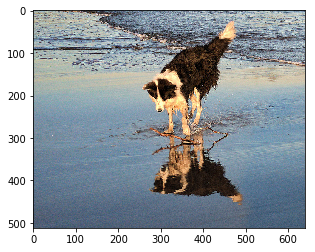

In [0]:
img=mpimg.imread('example.jpg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
photo = extract_features('example.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq black dog is running through the water endseq


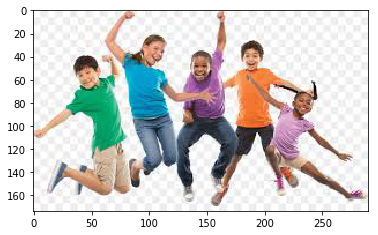

In [0]:
img=mpimg.imread('example5.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
photo = extract_features('example5.jpeg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq two children are playing in the snow endseq


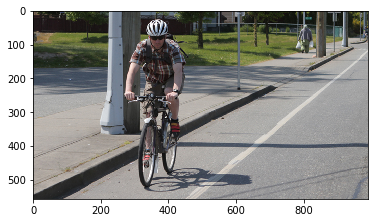

In [0]:
img=mpimg.imread('example4.jpg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
photo = extract_features('example4.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man in red shirt is riding bike on the street endseq


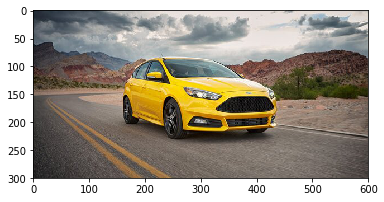

In [0]:
img=mpimg.imread('example3.jpg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
photo = extract_features('example3.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq two dogs are racing on the track endseq


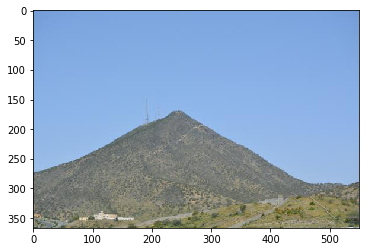

In [0]:
img=mpimg.imread('example6.jpg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
photo = extract_features('example6.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man is climbing rock face endseq


In [0]:
train_descriptions

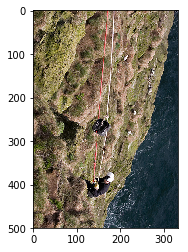

REAL: startseq person climbing down rocky cliffside with water below endseq


In [0]:
img=mpimg.imread('./Flickr8k_Dataset/Flicker8k_Dataset/2255342813_5b2ac6d633.jpg')
imgplot = plt.imshow(img)
plt.show()

print ("REAL:", train_descriptions['2255342813_5b2ac6d633'][0])

In [0]:
photo = extract_features('./Flickr8k_Dataset/Flicker8k_Dataset/2255342813_5b2ac6d633.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man is climbing rock face endseq


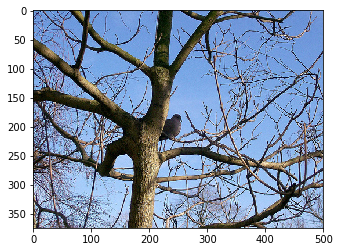

REAL: startseq bird sits in leafless tree endseq


In [0]:
img=mpimg.imread('./Flickr8k_Dataset/Flicker8k_Dataset/2255266906_8222af18b9.jpg')
imgplot = plt.imshow(img)
plt.show()

print ("REAL:", train_descriptions['2255266906_8222af18b9'][0])

In [0]:
photo = extract_features('./Flickr8k_Dataset/Flicker8k_Dataset/2255266906_8222af18b9.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq two children are playing in the snow endseq


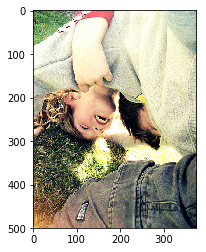

REAL: startseq couple of playful kids in sweats and jeans romp on the grass endseq


In [0]:


img=mpimg.imread('./Flickr8k_Dataset/Flicker8k_Dataset/2257631407_1529b9db39.jpg')
imgplot = plt.imshow(img)
plt.show()

print ("REAL:", train_descriptions['2257631407_1529b9db39'][0])

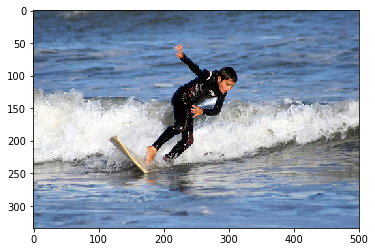

REAL: startseq child in black wetsuit is in the waves on surfboard endseq


In [0]:


img=mpimg.imread('./Flickr8k_Dataset/Flicker8k_Dataset/2258662398_2797d0eca8.jpg')
imgplot = plt.imshow(img)
plt.show()

print ("REAL:", train_descriptions['2258662398_2797d0eca8'][0])

In [0]:
photo = extract_features('./Flickr8k_Dataset/Flicker8k_Dataset/2258662398_2797d0eca8.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man in blue is in the water endseq
